## Shapley effects for RC and $\theta_{11}$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import chaospy as cp
import seaborn as sns
import profile
from functools import partial
from ruspy.estimation.estimation import estimate
#from ruspy.simulation.simulation import simulate
from ruspy.model_code.fix_point_alg import calc_fixp
from ruspy.model_code.cost_functions import lin_cost
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.estimation.estimation_transitions import create_transition_matrix
from ruspy.model_code.demand_function import get_demand 
from python.econsa_shapley import get_shapley
from python.econsa_shapley import _r_condmvn
from python.sampling import simulate_cov_and_mean_rc_theta_11
from python.sampling import approx_comp_time

In [2]:
run_simulation = False

In [3]:
# Set simulating variables.
disc_fac = 0.9999
num_buses = 50
num_periods = 120
gridsize = 1000
# We use the cost parameters and transition probabilities from the replication.
params = np.array([10.07780762, 2.29417622])
trans_probs = np.array([0.39189182, 0.59529371, 0.01281447])
scale = 1e-3

init_dict_simulation = {
    "simulation": {
        "discount_factor": disc_fac,
        "periods": num_periods,
        "seed": 123,
        "buses": num_buses,
    },
    "plot": {"gridsize": gridsize},
}

In [4]:
# Calcualte objects necessary for the simulation process. See documentation for details.
# Discretization of the state space.
# Originally 200. 90 (with a size of 5,000 miles each) and 175 (with a size of 2,571) 
# bins were used by Rust (1987).
num_states = 175
costs = calc_obs_costs(num_states, lin_cost, params, scale)

trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(trans_mat, costs, disc_fac)[0]

In [5]:
# Use one init_dict for get_demand() and estimate().
init_dict_estimation = {
    'model_specifications': {
        'discount_factor': disc_fac,
        'number_states': num_states,
        'maint_cost_func': 'linear',
        'cost_scale': 1e-3
    },
    'optimizer': {
        'approach': 'NFXP',
        'algorithm': 'scipy_L-BFGS-B',
        'gradient': 'Yes'
    },
    
}

In [6]:
%%time
if run_simulation == True:
    num_sim = 5000
    cov, mean = simulate_cov_and_mean_rc_theta_11(num_sim, ev, costs, trans_mat, init_dict_simulation, init_dict_estimation)
    np.save(os.path.join('data', 'cov_rc_theta_11'), cov)
    np.save(os.path.join('data', 'mean_rc_theta_11'), mean)
else:
    cov = np.load(os.path.join('data', 'cov_rc_theta_11.npy'))
    mean = np.load(os.path.join('data', 'mean_rc_theta_11.npy'))

Wall time: 4.99 ms


In [14]:
# 50 min (conservative estimate) per 1,000 simulations. From 1,000 to 2,000 I did 0.05 better.
print('If n_sim = 10,000, I need', 50 * 10 / 60, 'hours')
# Assume always by 0.05 closer to true value for 1,000 more sim.s.
10.5 - 0.05 * 9
# If this was true, should approach true value with 10,000 sim.s.

If n_sim = 10,000, I need 8.333333333333334 hours


10.05

In [7]:
cov_nice = pd.DataFrame(data=cov, index= ['$RC$', '$\theta_{11}$'], columns=['$RC$', '$\theta_{11}$'])

In [8]:
cov_nice

,$RC$,$\theta_{11}$
$RC$,1.671083,0.636662
$\theta_{11}$,0.636662,0.288380


In [9]:
mean_nice = pd.DataFrame(data=np.concatenate((mean, params)).reshape([2, 2], order='F'), 
                         index= ['$RC$', '$\theta_{11}$'], columns=['Empirical mean', 'True mean'])

In [10]:
mean_nice

,Empirical mean,True mean
$RC$,10.450362,10.077808
$\theta_{11}$,2.439941,2.294176


In [55]:
# Test: save data frame as .csv.
mean_nice.to_pickle(path_or_buf=os.path.join('data', 'mean_nice'))

Define functions `rust_model()`, and function arguments.

In [34]:
def x_all(n):
    distribution = cp.MvNormal(mean, cov)
    return distribution.sample(n)

def x_cond(n, subset_j, subsetj_conditional, xjc):
    if subsetj_conditional is None:
        cov_int = np.array(cov)
        cov_int = cov_int.take(subset_j, axis=1)
        cov_int = cov_int[subset_j]
        distribution = cp.MvNormal(mean[subset_j], cov_int)
        return distribution.sample(n)
    else:
        return _r_condmvn(
            n,
            mean=mean,
            cov=cov,
            dependent_ind=subset_j,
            given_ind=subsetj_conditional,
            x_given=xjc,
        )

In [35]:
def rust_model(x):
    if method == 'exact':
        n_evaluations = n_output + np.math.factorial(n_inputs) * (n_inputs -1) * n_outer * n_inner
    elif method == 'random':
        n_evaluations = n_output + n_perms * (n_inputs -1) * n_outer * n_inner
        
    demand_inputs = np.zeros((n_evaluations, 5))
    demand_inputs[:, :3] = trans_probs
    demand_inputs[:, 3:] = x[:, :]
    
    demand_output = np.zeros((n_evaluations, 1))
    
    # Second, try with list comprehension (do not need to define demand_output first).
    #demand_output = [get_demand(init_dict_estimation, demand_dict, demand_inputs[sample, :]).iloc[0]['demand'] 
    #                for sample in np.arange(n_evaluations)]
    
    # First try with for loop.
    #for sample in np.arange(n_evaluations):
    #    demand_params = demand_inputs[sample, :]
    #    demand_output[sample] = get_demand(init_dict_estimation, demand_dict, demand_params).iloc[0]['demand']
    
    get_demand_partial = partial(get_demand, init_dict=init_dict_estimation, demand_dict=demand_dict)
    def get_demand_mapping(x):
        return get_demand_partial(demand_params=x).iloc[0]['demand']
    
    demand_output = np.array(list(map(get_demand_mapping, demand_inputs)))
    
    return demand_output

In [30]:
# Need demand at certain value of RC only.  Note RC is scaled by 1e-03.
demand_dict = {
    "RC_lower_bound": 11.5,
    "RC_upper_bound": 11.5,
    "demand_evaluations": 1,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}

In [31]:
n_inputs = 2
method = 'exact'
np.random.seed(1234)

if method == 'exact':
    n_perms = None
elif method == 'random':
    n_perms = 10
n_output = 10**3
n_outer = 15
n_inner = 3

Run `get_shapley()` ten times for small simulation numbers.

In [33]:
n_inputs = 2
method = 'exact'
np.random.seed(1234)

if method == 'exact':
    n_perms = None
elif method == 'random':
    n_perms = 10
n_output = 10**2
n_outer = 10
n_inner = 3

In [37]:
%%time

exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 51.6 s


In [45]:
%%time
# For loop. Get a sense of how it works. Later get functions and run for larger number of simulations.
shapley_effects = {}
for i in np.arange(10):
    np.random.seed(i)
    exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
    exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)
    shapley_effects[i] = exact_shapley
    print('Run', i + 1)

Run 1 

Run 2 

Run 3 

Run 4 

Run 5 

Run 6 

Run 7 

Run 8 

Run 9 

Run 10 

Wall time: 10min 6s


In [59]:
shapley_effects[i]['Shapley effects']['$RC$']

0.380728832109027

In [162]:
# Get data frame suitable for plotting.
rc_shapley_effects = [shapley_effects[i]['Shapley effects']['$RC$'] for i in np.arange(10)]
theta_shapley_effects = [shapley_effects[i]['Shapley effects']['$\theta_{11}$'] for i in np.arange(10)]

rc_shapley_effects_df = pd.DataFrame(data=rc_shapley_effects)
rc_shapley_effects_df['input_variable'] = 'rc'

theta_shapley_effects_df = pd.DataFrame(data=theta_shapley_effects)
theta_shapley_effects_df['input_variable'] = 'theta'

data = pd.concat([rc_shapley_effects_df, theta_shapley_effects_df], ignore_index=True)
data.rename(columns={0: 'shapley_effect'}, inplace=True)

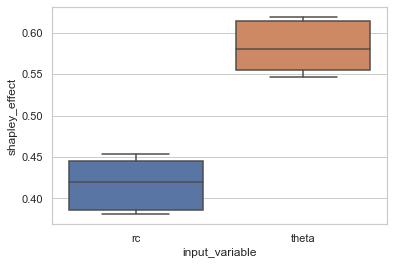

In [165]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x=data['input_variable'], y=data['shapley_effect'])

In [166]:
fig.savefig(fname=os.path.join('figures', 'boxplot_shapley_effects'), dpi=1000)

#### Try to run `get_shapley()` ten times in a function.

In [ ]:
def shapley_ten(model):
    ten_shapley_dict = {}
    
    # Set simulating variables.
    disc_fac = 0.9999
    num_buses = 50
    num_periods = 120
    gridsize = 1000
    # We use the cost parameters and transition probabilities from the replication.
    params = np.array([10.07780762, 2.29417622])
    trans_probs = np.array([0.39189182, 0.59529371, 0.01281447])
    scale = 1e-3

    init_dict_simulation = {
        "simulation": {
            "discount_factor": disc_fac,
            "periods": num_periods,
            "seed": 123,
            "buses": num_buses,
        },
        "plot": {"gridsize": gridsize},
    }
    
    # Need demand at certain value of RC only.  Note RC is scaled by 1e-03.
    demand_dict = {
        "RC_lower_bound": 11.5,
        "RC_upper_bound": 11.5,
        "demand_evaluations": 1,
        "tolerance": 1e-10,
        "num_periods": num_periods,
        "num_buses": num_buses,
    }
    
    

Run for large no. of MC runs.

In [11]:
n_output = 10**3
n_outer = 10**2
n_inner = 20
# Time in s for 100 model evaluations.
time_model_eval = 35
approx_comp_time(time_model_eval, method, n_inputs, n_perms, n_output, n_outer, n_inner)

 5000 model evaluations 
 approx.  0.4861111111111111 hours 
 approx. 29.166666666666668 minutes


In [12]:
%%time

exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 33min 15s


In [13]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.422186,0.29853,-0.162934,1.007305
theta_11,0.577814,0.29853,-0.007305,1.162934


Another try with even larger no.s

In [20]:
n_output = 10**3
n_outer = 10**2
n_inner = 40
# Time in s for 100 model evaluations.
time_model_eval = 37
approx_comp_time(time_model_eval, method, n_inputs, n_perms, n_output, n_outer, n_inner)

 9000 model evaluations 
 approx.  0.925 hours 
 approx. 55.5 minutes


In [18]:
%%time

exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 1h 3min 57s


In [19]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.413136,0.292131,-0.159441,0.985713
theta_11,0.586864,0.292131,0.014287,1.159441


In [18]:
list_num_sim = [{'n_output': 10**3, 'n_outer': 15, 'n_inner': 3}, 
                {'n_output': 10**3, 'n_outer': 15, 'n_inner': 5}, 
                {'n_output': 10**3, 'n_outer': 15, 'n_inner': 7}, 
                {'n_output': 10**3, 'n_outer': 20, 'n_inner': 3}, 
                {'n_output': 10**3, 'n_outer': 20, 'n_inner': 7}]

In [12]:
%%time

exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 6min 44s


In [13]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.425934,0.301181,-0.164381,1.016249
theta_11,0.574066,0.301181,-0.016249,1.164381


Try with larger no. of MC runs.

In [29]:
%%time
n_output = 10**2
n_outer = 40
n_inner = 20
exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 11min 22s


In [30]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.437425,0.309306,-0.168815,1.043666
theta_11,0.562575,0.309306,-0.043666,1.168815


In [27]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.386826,0.273527,-0.149287,0.922939
theta_11,0.613174,0.273527,0.077061,1.149287


#### Run the following code over night 

In [54]:
n_output = 20**3
n_outer = 20**2
n_inner = 10**2
# Time in s for 100 model evaluations.
time_model_eval = 40
approx_comp_time(time_model_eval, method, n_inputs, n_perms, n_output, n_outer, n_inner)

 88000 model evaluations 
 approx.  9.777777777777779 hours 
 approx. 586.6666666666667 minutes


In [ ]:
exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

#### Run for $RC_{fixed}$ close to true $RC$

In [12]:
# Need demand at certain value of RC only.  Note RC is scaled by 1e-03.
demand_dict = {
    "RC_lower_bound": 10.0,
    "RC_upper_bound": 10.0,
    "demand_evaluations": 1,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}

In [13]:
%%time
n_output = 10**3
n_outer = 15
n_inner = 3
exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 5min 10s


In [14]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.425773,0.301067,-0.164318,1.015864
theta_11,0.574227,0.301067,-0.015864,1.164318


## Uncertainty Propagation
Inspection of the distribution of the implied demand at certain $RC_{fixed}$.

In [7]:
# Sample data.
n_sim_demand = 1000
input_variables = cp.MvNormal(mean, cov).sample(n_sim_demand).T

In [8]:
# Need demand at certain value of RC only.  Note RC is scaled by 1e-03.
demand_dict = {
    "RC_lower_bound": 11.5,
    "RC_upper_bound": 11.5,
    "demand_evaluations": 1,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}

In [9]:
get_demand_partial = partial(get_demand, init_dict=init_dict_estimation, demand_dict=demand_dict)
def get_demand_mapping(x):
    return get_demand_partial(demand_params=x).iloc[0]['demand']

In [10]:
demand_inputs = np.zeros((n_sim_demand, 5))
demand_inputs[:, :3] = np.array([0.39189182, 0.59529371, 0.01281447])
demand_inputs[:, 3:] = input_variables[:, :]

In [11]:
%%time
implied_demand = np.array(list(map(get_demand_mapping, demand_inputs)))

Wall time: 6min 39s


In [12]:
true_demand_params = np.concatenate((trans_probs, params))
true_implied_demand = get_demand(init_dict_estimation, demand_dict, true_demand_params).iloc[0]['demand']

In [13]:
true_implied_demand

59.08876063087759

In [14]:
mean_implied_demand = np.mean(implied_demand)

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.0, ''),
 Text(0, 0.01, ''),
 Text(0, 0.02, ''),
 Text(0, 0.03, ''),
 Text(0, 0.04, ''),
 Text(0, 0.05, ''),
 Text(0, 0.06, ''),
 Text(0, 0.07, ''),
 Text(0, 0.08, '')]

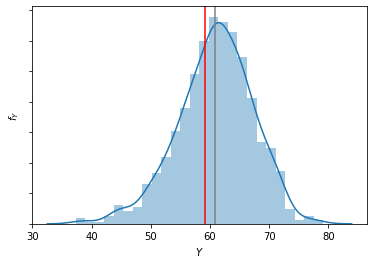

In [16]:
fig, ax = plt.subplots()

sns.distplot(implied_demand)

ax.set_xlabel(r"$Y$")
ax.set_ylabel(r"$f_Y$")

ax.axvline(x=true_implied_demand, ymin=0, ymax=1, color='red')

ax.axvline(x=mean_implied_demand, ymin=0, ymax=1, color='grey')

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.axes.get_yaxis().set_ticklabels([])

In [19]:
# Save to png.
fig.savefig(fname=os.path.join('figures', 'uncertainty_propagation'), dpi=1000)